# Case 2. Pneumonia X-ray image analysis
**Neural Networks for Machine Learning Applications**<br>
7.2.2023<br>
Joona Nylander, Lassi Piispanen and Antti Taponen<br>
[Information Technology, Bachelor's Degree](https://www.metropolia.fi/en/academics/bachelors-degrees/information-technology)<br>
[Metropolia University of Applied Sciences](https://www.metropolia.fi/en)

## 1. Introduction
The goal of this notebook is to create a binary classification for X-ray images based on if the patient has pneumonia or not. This will be achieved using a convolutional neural network and multiple models are to be compared with each other.

## 2. Setup
The main library used to build the convolutional neural network is Tensorflows Keras library.

In addition to Tensorflow and Keras, matplotlib.pyplot is imported for result visualization.

In [ ]:
import tensorflow as tf
import os                       # Used to access files
import matplotlib.pyplot as plt # Used to plot graphs

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 3. Dataset
The original dataset used to train the convolutional neural network is Mendeley Data. https://data.mendeley.com/datasets/rscbjbr9sj/2

The original dataset contains x-ray images of varying dimensions. The data is stored as sets of two for classification purposes. The division of the different classes for the samples is done via a folder system where one folder contains the x-rays of the healthy individuals and another contains the x-rays of the individuals with pneumonia. In addition to this there are two parent folders containing folders of both healthy and sick samples. These parent folders are used for splitting the data into training and testing datasets.

Because of how the original data was split into train and test sets we resplit and rearranged the data locally with a borrowed python code and then uploaded the new dataset to Google Drive.

The new dataset now has three folders; train, validation and test.

In [ ]:
# Images are loaded from Google Drive

dir = '/content/gdrive/Shareddrives/Neuroverkot/Juha/case2/Case2_XRay'
!ls $dir

test  train  validation


In [ ]:
train_dir = os.path.join(dir,'train')
validation_dir = os.path.join(dir,'validation')
test_dir = os.path.join(dir,'test')

train_names_normal = os.listdir(os.path.join(train_dir,'NORMAL'))
train_names_pneumonia = os.listdir(os.path.join(train_dir,'PNEUMONIA'))

val_names_normal = os.listdir(os.path.join(validation_dir,'NORMAL'))
val_names_pneumonia = os.listdir(os.path.join(validation_dir,'PNEUMONIA'))

test_names_normal = os.listdir(os.path.join(test_dir,'NORMAL'))
test_names_pneumonia = os.listdir(os.path.join(test_dir,'PNEUMONIA'))

print('Train directory:')
print(len(train_names_normal),'normal images')
print(len(train_names_pneumonia),'pneumonia images') 

print('Validation directory:')
print(len(val_names_normal),'normal images')
print(len(val_names_pneumonia),'pneumonia images') 

print('Test directory:')
print(len(test_names_normal),'normal images')
print(len(test_names_pneumonia),'pneumonia images')

Train directory:
949 normal images
2574 pneumonia images
Validation directory:
317 normal images
855 pneumonia images
Test directory:
317 normal images
855 pneumonia images


## 4. Preprocessing

Preprocessing of the dataset was quite straightforward due to Keras image preprocessing module which does everything needed to do.

For some of our convolutional neural network models we used data augmentation, which was also performed with the same image preprocessing module.

Train and validation sets are loaded from Google Drive directory. For this model all the images are resized to 300 by 300 pixels size. The image size has effect on how many Max Pooling 2D (both dimensions divided by 2) can be performed on the image. With bigger image size even smaller features can be extracted from the image, but the time to train the network grows because convolutional layers has more work to do.

Also RGB values (ranging from 0 to 255) of the images are rescaled to range from 0 to 1.

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=(300,300), batch_size=32,
    class_mode='binary')

validation_generator = datagen.flow_from_directory(
    validation_dir, target_size=(300,300), batch_size=32,
    class_mode='binary')

Found 3522 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


## 5. Modeling

### 5.1 Chosen model

The model we chose has six convolutional layers with filter numbers of 8, 16, 32, 32, 64 and 128, following with a single 256 neuron dense layer and finally single neuron output layer. After every convolutional layer max pooling is performed.

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(8, (3, 3), activation='relu',
    input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 32)       0

The model is compiled using Adam optimizer, which was chosen based on experience from several models being trained.

The loss function Binary Cross Entropy is the obvious choice for a binary classification problem.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam',
    metrics=['Accuracy','Recall'])

### 5.2 Other models

#### Pre-trained model with VGG16

One of our models was done with VGG16 pre-trained network which performed exceptionally good considering the ease of use and how fast it was to train the rest of the network after VGG16 had done it's job.

VGG16 was chosen based on discussion and its popularity on internet. We also did several training runs with different pre-trained networks and VGG16 performed best.

With only one dense layer containing 256 neurons and single neuron output layer after the pre-trained network ~96% validation accuracy was achieved. Here Adam was also used as optimizer. Image size was set to 150 by 150 pixels.

Data augmentation was used for the dataset and the RGB values were rescaled to be between 0 and 1.

Although this model was slightly better than our chosen one we did not want to choose this model because all we had to do was add a single dense layer to it.

In [ ]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False,
                  input_shape=(150,150,3))

conv_base.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
model2 = models.Sequential()

model2.add(layers.Dense(256, activation='relu', input_shape=(4*4*512,)))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


#### Third model

Our third model is following:

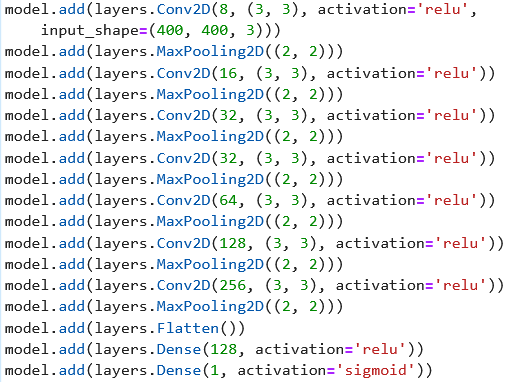





We tried to use a bit bigger image size and deeper network which resulted in a longer training time but the performance was about the same or sligthly worse than with our chosen model (~95% validation accuracy). Adam was used as optimizer here aswell.

## 6. Training

The chosen model is trained using the training dataset and validated using the validation set during the training. From several training runs and inspection of the accuracy and loss curves epoch count of 12 was chosen, which seemed to be the peak after the model started to overfit.

Steps per epoch for both training and validation was calculated from the corresponding sets size divided by data generators batch size.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=109, epochs=12,
    validation_data=validation_generator, validation_steps=36, verbose=0)

## 7. Performance and evaluation

### 7.1 Loss and accuracy graphs of training and validation

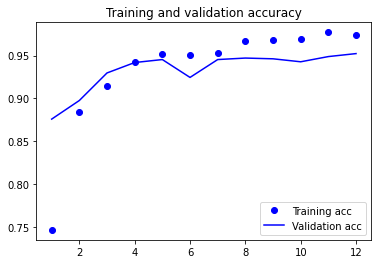

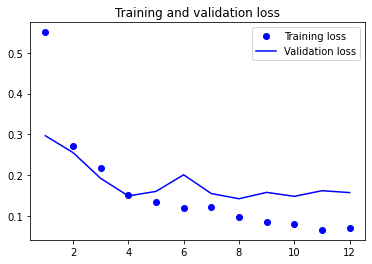

In [ ]:
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
print("Training accuracy:", acc[11])
print("Validation accuracy:", val_acc[11])

print("Training recall:", recall[11])
print("Validation recall:", val_recall[11])

Training accuracy: 0.9736841917037964
Validation accuracy: 0.9522569179534912
Training recall: 0.980997622013092
Validation recall: 0.9630952477455139


The model has accuracy of ~95% with validation data and recall of 96%, which both exceeds the goal of 90%.

From the graphs we can see that the sweet spot might actually have been at epoch 8, instead of 12.

### 7.2 Final evaluation with test set

In [ ]:
test_generator = datagen.flow_from_directory(test_dir,
    target_size=(300, 300),batch_size=32,
    class_mode='binary')

test_loss, test_acc, test_recall = model.evaluate(test_generator, steps=36)

print('test acc:', test_acc, 'test recall:', test_recall)

Found 1172 images belonging to 2 classes.
36/36 [==============================] - 154s 4s/step - loss: 0.1310 - Accuracy: 0.9462 - recall: 0.9515
test acc: 0.9461805820465088 test recall: 0.9514793157577515


Accuracy of ~95% aswell as recall was achieved on test set.

## 8. Discussion and conclusions

We quickly realized how resource extensive the training process of a neural network is. Because how time-consuming every training run was we trained our models locally.

To conclude, the best performing model was the one where we utilized a pre-trained network (VGG16). But in terms of how performance consuming the usage of the model was, our self built model was only around 1 percentage point worse in accuracy and sensitivity with around 14.5 million less parameters.

However, testing different pre-trained networks wasn't really making a difference towards accuracy or sensitivity. For example, we tried using a pre-trained network called "Xception" which was the top-rated network accuracywise in the Keras documentation. A model using Xception happened to  yield results with an accuracy of 94%. 

Even though on paper it should've been the best pre-trained network to use, it didn't appear to be so in this exact problem. The pre-trained networks are for a general purpose use, and we think that with more time we could've modified them to perform even better.